In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller

In [1]:
# Set to False to run on all symbols
demo = True

### 1. Process definition

#### 1.1 Devolatization part

In [2]:
def calculate_realized_volatility(high_freq_prices):
    """
    Calculate realized volatility using high-frequency price data.
    Args:
        high_freq_prices (pd.Series): High-frequency price series (e.g., 5-minute prices).
    Returns:
        pd.Series: Realized volatility for each interval.
    """
    high_freq_prices['log_price'] = np.log(high_freq_prices['close'])
    high_freq_prices['log_diff'] = high_freq_prices['log_price'].diff() ** 2
    realized_volatility = high_freq_prices.groupby(high_freq_prices['timestamp'].dt.date)['log_diff'].sum().apply(np.sqrt)
    return realized_volatility

In [3]:
def devolatize_data(low_freq_prices, realized_volatility):
    """
    Devolatize log-price increments using realized volatility.
    Args:
        low_freq_prices (pd.Series): Low-frequency price series (daily).
        realized_volatility (pd.Series): Realized volatility corresponding to the low-frequency intervals.
    Returns:
        pd.Series: Devolatized log-price increments.
    """
    low_freq_prices['log_price'] = np.log(low_freq_prices['close'])
    low_freq_prices['log_diff'] = low_freq_prices['log_price'].diff()
    low_freq_prices['realized_volatility'] = low_freq_prices['timestamp'].dt.date.map(realized_volatility)
    low_freq_prices['scaled_diff'] = low_freq_prices['log_diff'] / low_freq_prices['realized_volatility']
    low_freq_prices['devol_price'] = low_freq_prices['scaled_diff'].cumsum()
    return low_freq_prices.dropna()

#### 1.2 Run estimation statistics & critical values

In [4]:
def recursive_dickey_fuller(devolatized_series, tau0=0.1):
    """
    Perform the recursive Dickey-Fuller test on the devolatized series.
    Args:
        devolatized_series (pd.Series): Devolatized series to test for explosiveness.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
    Returns:
        float: Supremum of the Dickey-Fuller test statistics.
    """
    n = len(devolatized_series)
    min_sample_size = int(tau0 * n)
    sup_stat = -np.inf

    for tau in range(min_sample_size, n + 1):
        sub_sample = devolatized_series.iloc[:tau]
        result = adfuller(sub_sample['devol_price'], maxlag=0, regression='c')
        sup_stat = max(sup_stat, result[0])

    return sup_stat

In [5]:
def estimate_critical_values(series_length, n_simulations=200, significance_levels=[0.01, 0.05, 0.1]):
    """
    Estimate critical values for the RVDF test using simulations.
    Args:
        series_length (int): Length of the time series.
        n_simulations (int): Number of simulations to run.
        significance_levels (list): List of significance levels (e.g., [0.01, 0.05, 0.1]).
    Returns:
        dict: Critical values for each significance level.
    """
    simulated_stats = []

    for _ in range(n_simulations):
        simulated_series = np.random.normal(0, 1, series_length).cumsum()
        df = pd.DataFrame(simulated_series, columns=['devol_price'])
        stat = recursive_dickey_fuller(df)
        simulated_stats.append(stat)

    critical_values = {}
    for alpha in significance_levels:
        critical_values[alpha] = np.percentile(simulated_stats, 100 * (1 - alpha))

    return critical_values

In [6]:
def test_explosiveness_with_rvpwy(devolatized_series, tau0=0.1):
    """
    Perform the RVPWY test for explosiveness.
    Args:
        devolatized_series (pd.Series): Devolatized series to test for explosiveness.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
    Returns:
        dict: Test statistic and critical values.
    """
    sup_stat = recursive_dickey_fuller(devolatized_series, tau0)

    return sup_stat

#### 1.3 Rolling RVDF

In [7]:
def rolling_dickey_fuller(devolatized_series, tau0=0.1):
    """
    Compute rolling Dickey-Fuller test statistics for the devolatized series.
    Args:
        devolatized_series (pd.Series): Devolatized series to test for explosiveness.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
    Returns:
        pd.Series: Time series of rolling Dickey-Fuller test statistics.
    """
    n = len(devolatized_series)
    min_sample_size = int(tau0 * n)
    test_stats = []
    dates = []

    for tau in range(min_sample_size, n):
        sub_sample = devolatized_series.iloc[:tau]
        result = adfuller(sub_sample['devol_price'], maxlag=0, regression='c')
        test_stats.append(result[0])
        dates.append(devolatized_series['timestamp'].iloc[tau])
    
    df = pd.DataFrame({"timestamp": dates, "test_stats": test_stats})

    return df

#### 1.4 Date Stamping Explosive periods

In [8]:
def date_stamping_all_periods(devolatized_series, critical_value, tau0=0.1):
    """
    Date-stamp all periods of explosive behavior.
    Args:
        devolatized_series (pd.Series): Devolatized series to test for explosiveness.
        critical_value (float): Critical value for the Dickey-Fuller test.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
    Returns:
        list: List of tuples with origination and conclusion dates for each explosive period.
    """
    n = len(devolatized_series)
    min_sample_size = int(tau0 * n)
    periods = []
    start = min_sample_size

    while start < n:
        # Find origination date
        origination_date = None
        for i in range(start, n):
            sub_sample = devolatized_series.iloc[:i]
            result = adfuller(sub_sample['devol_price'], maxlag=0, regression='c')
            if result[0] > critical_value:
                origination_date = devolatized_series['timestamp'].iloc[i]
                start = i
                break

        if origination_date is None:
            break

        # Find conclusion date
        conclusion_date = None
        offset = int(np.ceil(np.log(n) / n))
        for i in range(start + offset, n):
            sub_sample = devolatized_series.iloc[:i]
            result = adfuller(sub_sample['devol_price'], maxlag=0, regression='c')
            if result[0] < critical_value:
                conclusion_date = devolatized_series['timestamp'].iloc[i]
                start = i + 1
                break

        if conclusion_date is None:
            conclusion_date = devolatized_series['timestamp'].iloc[-1]
            start = n

        periods.append((origination_date, conclusion_date))

    return periods

#### 1.5 Plotting Results

In [9]:
def plot_devolatization(low_freq_prices, realized_volatility, devolatized_series):
    """
    Plot the devolatization process.
    Args:
        low_freq_prices (pd.DataFrame): Low-frequency price data.
        realized_volatility (pd.Series): Realized volatility for each interval.
        devolatized_series (pd.Series): Devolatized series.
    """

    _, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot low-frequency prices
    ax[0].plot(low_freq_prices['timestamp'], low_freq_prices['close'])
    ax[0].set_title('Low-Frequency Prices')
    ax[0].set_xlabel('Date')

    # Plot realized volatility
    ax[1].plot(realized_volatility)
    ax[1].set_title('Realized Volatility')
    ax[1].set_xlabel('Date')

    # Plot devolatized series
    ax[2].plot(devolatized_series['timestamp'], devolatized_series['devol_price'])
    ax[2].set_title('Devolatized Log-Price Series')
    ax[2].set_xlabel('Date')

    plt.tight_layout()
    plt.show()

In [10]:
def plot_rvdf_detector(low_freq_prices, devolatized_series, critical_value, significance, tau0=0.1):
    """
    Plot the RVDF detector for the devolatized series.
    Args:
        devolatized_series (pd.Series): Devolatized series to test for explosiveness.
        critical_value (float): Critical value for the Dickey-Fuller test.
        significance (float): Significance level for the critical value.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
    """
    test_stats = rolling_dickey_fuller(devolatized_series, tau0)

    test_stats['timestamp'] = pd.to_datetime(test_stats['timestamp']).dt.tz_localize(None)
    low_freq_prices['timestamp'] = pd.to_datetime(low_freq_prices['timestamp']).dt.tz_localize(None)
    test_stats = test_stats.merge(low_freq_prices, how='left', on='timestamp')

    # Plot test statistics
    plt.figure(figsize=(10, 6))
    plt.plot(test_stats['timestamp'], test_stats['test_stats'], label="RVDF Test Statistic")
    plt.axhline(y=critical_value, color='r', linestyle='--', label=f"Critical Value ({significance*100}%)")
    plt.axhline(y=0, color='k', linestyle='-')

    # Plot prices on second y axis
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(test_stats['timestamp'], test_stats['close'], color='gray', alpha=0.5, label="Price")

    # Set labels for y axes
    ax.set_ylabel("Test Statistic")
    ax2.set_ylabel("Price")

    # Plot a common legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right')

    plt.title("RVDF Detector for Explosive Behavior")
    plt.xlabel("Time")
    plt.grid()
    plt.show()

In [11]:
def plot_multiple_rvdf_detectors(low_freq_prices_dict, devolatized_series_dict, critical_value, significance, tau0=0.1, symbols=None):
    """
    Plot RVDF detectors for multiple devolatized series on a grid of subplots.
    
    Args:
        low_freq_prices_dict (dict): Dictionary where keys are series names and values are dataframes containing price data with 'timestamp' and 'close'.
        devolatized_series_dict (dict): Dictionary where keys are names of the series and values are devolatized series (pd.Series).
        critical_value (float): Critical value for the Dickey-Fuller test.
        significance (float): Significance level for the critical value.
        tau0 (float): Fraction of the series to use as the minimum subsample size.
        symbols (dict, optional): Dictionary where keys are series names and values are symbols to display in subplot titles.
    """

    n_series = len(devolatized_series_dict)
    n_rows = math.ceil(n_series / 2)

    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows), sharex=True)
    axes = axes.flatten()

    for idx, (series_name, devolatized_series) in enumerate(devolatized_series_dict.items()):
        ax = axes[idx]
        
        test_stats = rolling_dickey_fuller(devolatized_series, tau0)
        
        low_freq_prices = low_freq_prices_dict[series_name]
        test_stats['timestamp'] = pd.to_datetime(test_stats['timestamp']).dt.tz_localize(None)
        low_freq_prices['timestamp'] = pd.to_datetime(low_freq_prices['timestamp']).dt.tz_localize(None)
        test_stats = test_stats.merge(low_freq_prices, how='left', on='timestamp')

        # Plot test statistics
        ax.plot(test_stats['timestamp'], test_stats['test_stats'], label="RVDF Test Statistic")
        ax.axhline(y=critical_value, color='r', linestyle='--', label=f"Critical Value ({significance*100}%)")
        ax.axhline(y=0, color='k', linestyle='-')

        # Plot prices on second y axis
        ax2 = ax.twinx()
        ax2.plot(test_stats['timestamp'], test_stats['close'], color='gray', alpha=0.5, label="Price")

        # Set labels and titles
        symbol = symbols.get(series_name, "") if symbols else ""
        ax.set_title(f"RVDF Detector: {symbol}")
        ax.set_ylabel("Test Statistic")
        ax2.set_ylabel("Price")
        ax.grid()

        # Plot a common legend
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower right')

    # Hide any unused subplots
    for idx in range(len(devolatized_series_dict), len(axes)):
        fig.delaxes(axes[idx])

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()


### 2. Run on a selected symbol

In [104]:
symbol = 'SPY'
significance = 0.1

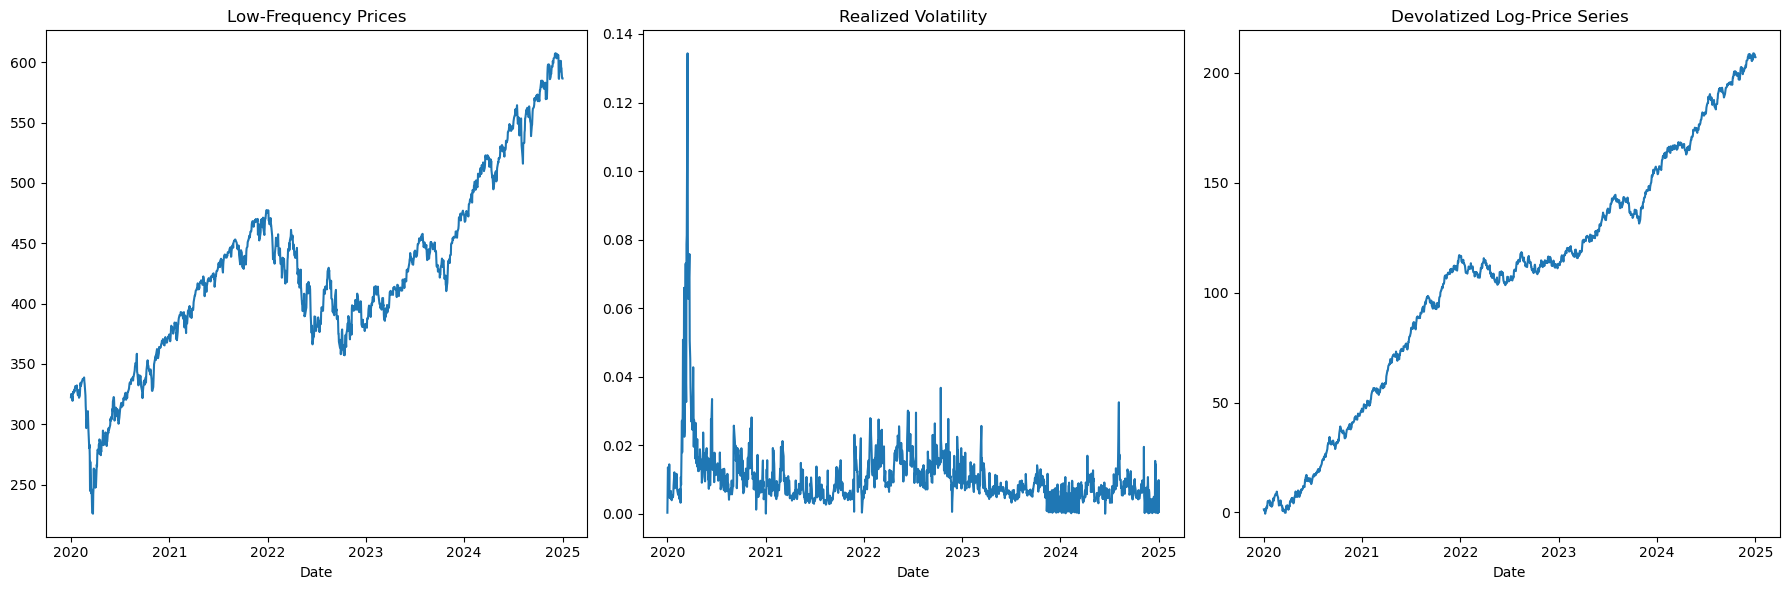

In [ ]:
# High-frequency price data
high_freq_prices = pd.read_csv(f"./data/{symbol}_5min.csv", parse_dates=['timestamp'])

# Low-frequency price data
low_freq_prices = pd.read_csv(f"./data/{symbol}_daily.csv", parse_dates=['timestamp'])

# Calculate realized volatility
realized_volatility = calculate_realized_volatility(high_freq_prices)

# Devolatize log-price increments
devolatized_series = devolatize_data(low_freq_prices, realized_volatility)

plot_devolatization(low_freq_prices, realized_volatility, devolatized_series)

In [78]:
# Simulate to get critical values
n = len(devolatized_series)
critical_values = estimate_critical_values(n)

In [83]:
# Step 3: Perform the RVPWY test
rvpwy_results = test_explosiveness_with_rvpwy(devolatized_series)
print(f"RVPWY Test Statistic: {rvpwy_results}")
print(f"Critical Values: {critical_values}")

RVPWY Test Statistic: 1.381475735245478
Critical Values: {0.01: 1.9847179170750815, 0.05: 1.6479674630082999, 0.1: 1.249794892144013}


In [107]:
# Step 4: Date-stamp all explosive periods
critical_value = critical_values[significance]
explosive_periods = date_stamping_all_periods(devolatized_series, critical_value)
for i, (start, end) in enumerate(explosive_periods):
    print(f"Explosive period {i + 1}: starts {start}, ends {end}")

Explosive period 1: starts 2020-09-03 00:00:00+00:00, ends 2020-09-04 00:00:00+00:00
Explosive period 2: starts 2021-08-26 00:00:00+00:00, ends 2021-08-27 00:00:00+00:00
Explosive period 3: starts 2021-08-31 00:00:00+00:00, ends 2021-09-08 00:00:00+00:00


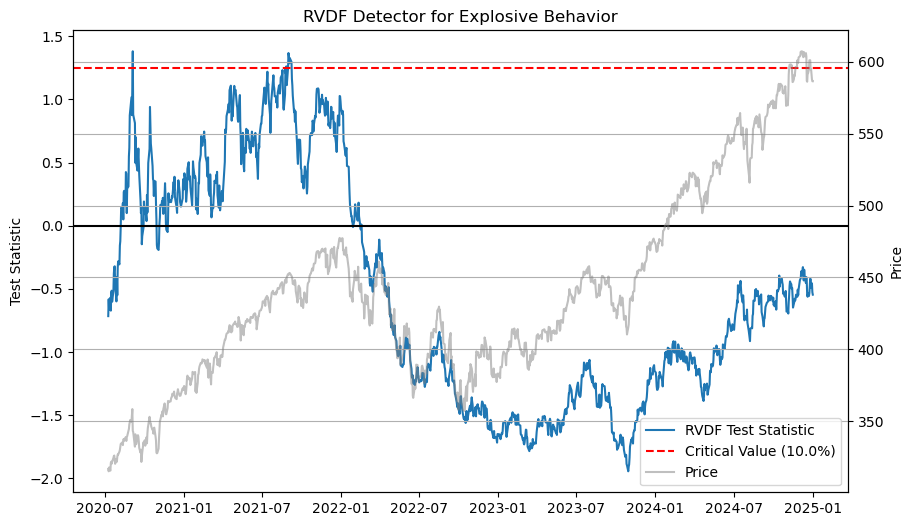

In [120]:
critical_value = critical_values[significance]
plot_rvdf_detector(low_freq_prices, devolatized_series, critical_value, significance)

### 3. Run on comparable symbols

In [2]:
symbols = ['BTC', 'ETH'] if demo else ['ASML', 'BRENT', 'EURUSD', 'EUS', 'JPM', 'NFLX', 'NOVOB', 'SPY', 'USDJPY', 'XOM', 'HKG', 'ADS', 'VOW3', 'XAUUSD', 'BTC', 'ETH']
significance = 0.1

In [37]:
# Estimate critical values initially
first_symbol = symbols[0]
low_freq_prices = pd.read_csv(f"./data/{first_symbol}_daily.csv", parse_dates=['timestamp'])
n = len(low_freq_prices)
critical_values = estimate_critical_values(n)
print(f"Critical Values: {critical_values}")

Critical Values: {0.01: 2.0221640842859303, 0.05: 1.404566476068176, 0.1: 1.1948089692512498}


In [38]:
devolatized_series_dict = {}
low_freq_prices_dict = {}
symbols_dict = {}

for symbol in symbols:
    # High-frequency price data
    high_freq_prices = pd.read_csv(f"./data/{symbol}_5min.csv", parse_dates=['timestamp'])

    # Low-frequency price data
    low_freq_prices = pd.read_csv(f"./data/{symbol}_daily.csv", parse_dates=['timestamp'])

    # Calculate realized volatility
    realized_volatility = calculate_realized_volatility(high_freq_prices)

    # Devolatize log-price increments
    devolatized_series = devolatize_data(low_freq_prices, realized_volatility)

    # RVPWY test
    rvpwy_results = test_explosiveness_with_rvpwy(devolatized_series)
    print(f"RVPWY Test Statistic: {rvpwy_results}")

    # Stamp the explosive periods
    critical_value = critical_values[significance]
    explosive_periods = date_stamping_all_periods(devolatized_series, critical_value)
    print(f"Explosive Periods for {symbol}:")
    for i, (start, end) in enumerate(explosive_periods):
        print(f"Explosive period {i + 1}: starts {start}, ends {end}")

    # Add series and low-frequency prices to dictionaries
    devolatized_series_dict[symbol] = devolatized_series
    low_freq_prices_dict[symbol] = low_freq_prices
    symbols_dict[symbol] = symbol

RVPWY Test Statistic: 0.6111287831998817
Explosive Periods for BTC:
RVPWY Test Statistic: -0.707700011647594
Explosive Periods for ETH:


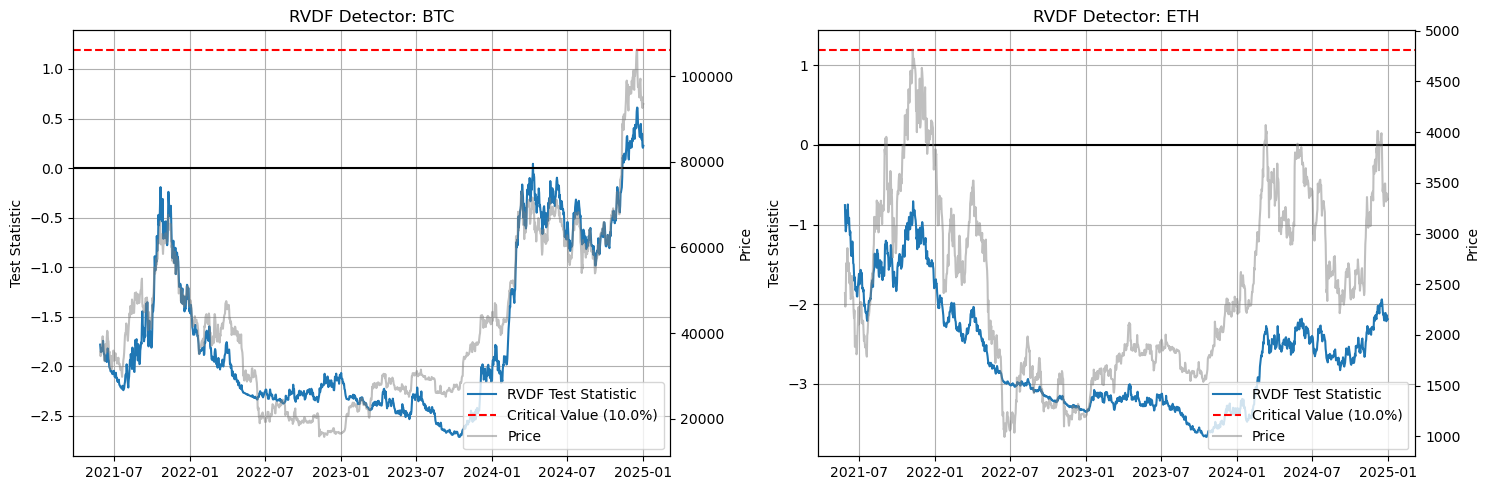

In [39]:
# Plot all series
plot_multiple_rvdf_detectors(low_freq_prices_dict, devolatized_series_dict, critical_value=critical_values[significance], significance=significance, symbols=symbols_dict)